## Libraries Import

In [1]:
import sys
sys.version

'3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:34:57) [MSC v.1936 64 bit (AMD64)]'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TrueNegatives, TruePositives, Precision, Recall, AUC 
import sklearn
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve
import warnings 
warnings.filterwarnings('ignore')

C:\Users\emage\anaconda3\envs\dlvenvs10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Get the list of physical devices
print(tf.config.list_physical_devices('GPU'))

[]


## Load Dataset

In [4]:
dataset, dataset_info = tfds.load('malaria', with_info=True,
                                  as_supervised=True,
                                  shuffle_files=True,
                                  split=['train'])

## Data Inspection

In [5]:
#
for data in dataset[0].take(1):
  print(data)
  break

(<tf.Tensor: shape=(151, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


## Train Test Val Dataset Split

In [6]:
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

dataset = tf.data.Dataset.range(10)
print(list(dataset.as_numpy_iterator()))

dataset_size = len(dataset)

train_dataset = dataset.take(int(train_ratio * dataset_size))
print(list(train_dataset.as_numpy_iterator()))

val_test_dataset = dataset.skip(int(train_ratio * dataset_size))
val_dataset = val_test_dataset.take(int(val_ratio * dataset_size))
print(list(val_dataset.as_numpy_iterator()))

test_dataset = val_test_dataset.skip(int(val_ratio * dataset_size))
print(list(test_dataset.as_numpy_iterator()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5]
[6, 7]
[8, 9]


In [7]:
# Defining the Function to split the data into train-val-test set
def split(dataset, train_ratio, val_ratio, test_ratio):
  dataset_size = len(dataset)

  train_dataset = dataset.take(int(train_ratio * dataset_size))

  val_test_dataset = dataset.skip(int(train_ratio * dataset_size))
  val_dataset = val_test_dataset.take(int(val_ratio * dataset_size))

  test_dataset = val_test_dataset.skip(int(val_ratio * dataset_size))

  return train_dataset, val_dataset, test_dataset


# Calling the Function
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2
dataset = tf.data.Dataset.range(10)
train_dataset, val_dataset, test_dataset = split(dataset, train_ratio, val_ratio, test_ratio)


# Print Output
list(train_dataset.as_numpy_iterator()), list(val_dataset.as_numpy_iterator()), list(test_dataset.as_numpy_iterator())

([0, 1, 2, 3, 4, 5], [6, 7], [8, 9])

### Spliting Malaria Dataset

In [8]:
dataset, dataset_info = tfds.load('malaria', with_info=True,
                                  as_supervised=True,
                                  shuffle_files=True,
                                  split=['train'])

In [9]:
# Calling the Function
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

train_dataset, val_dataset, test_dataset = split(dataset[0], train_ratio, val_ratio, test_ratio)

# Print Output
list(train_dataset.take(1).as_numpy_iterator()), list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator())

([(array([[[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           ...,
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]],
   
          [[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           ...,
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]],
   
          [[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           ...,
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]],
   
          ...,
   
          [[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           ...,
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]],
   
          [[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           ...,
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]],
   
          [[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           ...,
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]]], dtype=uint8),
   1)],
 [(array([[[0, 0, 0],
           [0, 0, 0],


## Dataset Visualisation

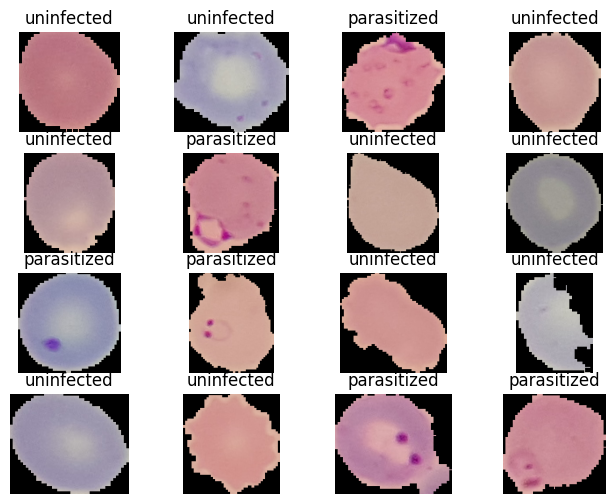

In [10]:
plt.figure(figsize=(8,6))

for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [11]:
dataset_info.features['label'].int2str(1)

'uninfected'

## Data Preprocessing

In [12]:
# Convertin the image size of 102x102 to a fixed size of 224x224
# Defining funcction to do so
im_size = 224
def resize_rescale(image, label):
  return tf.image.resize(image, (im_size, im_size))/255.0, label

In [13]:
# Applying the conversion to all train dataset
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

train_dataset, val_dataset, test_dataset

(<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

In [14]:
# Varify the conversion
for image, label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [15]:
# Suffeling the training dataset
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=8,
                                      reshuffle_each_iteration=True,
                                      ).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8,
                                      reshuffle_each_iteration=True,
                                      ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Sequential API

## Model

In [16]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(im_size, im_size, 3)),
    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='sigmoid'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='sigmoid'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(100, activation='sigmoid'),
    BatchNormalization(),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

lenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

# Functional API

In [17]:
# Input
func_input = Input(shape = (im_size, im_size, 3), name = 'Input Image') 

# Output
x = Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Flatten()(x)

x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation='sigmoid')(x)

lenet_model_func = Model(func_input, func_output, name='Lenet_Model')
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 16)      

## Compile

In [18]:
# Model Compiler
lenet_model_func.compile(optimizer=Adam(learning_rate=0.1),
              loss = BinaryCrossentropy(),
              metrics='accuracy'
              )

In [19]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [20]:
history = lenet_model_func.fit(train_dataset, validation_data = val_dataset, epochs=5, verbose=1)

Epoch 1/5



689/689 [==============================] - 289s 415ms/step - loss: 0.5784 - accuracy: 0.6972 - val_loss: 0.9093 - val_accuracy: 0.5285
Epoch 2/5
689/689 [==============================] - 293s 425ms/step - loss: 0.5916 - accuracy: 0.6907 - val_loss: 8.0235 - val_accuracy: 0.4958
Epoch 3/5
689/689 [==============================] - 293s 426ms/step - loss: 0.5520 - accuracy: 0.7309 - val_loss: 0.7633 - val_accuracy: 0.6000
Epoch 4/5
689/689 [==============================] - 281s 407ms/step - loss: 0.4884 - accuracy: 0.7765 - val_loss: 3.3996 - val_accuracy: 0.5129
Epoch 5/5
689/689 [==============================] - 282s 409ms/step - loss: 0.3210 - accuracy: 0.8792 - val_loss: 0.2600 - val_accuracy: 0.9274


# Feature Extractor

In [21]:
# Input
func_input = Input(shape = (im_size, im_size, 3), name = 'Input Image') 

# Output
x = Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size=2, strides=2)(x)

feature_extractor_model = Model(func_input, output, name='Feature_Extractor')
feature_extractor_model.summary()

Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_8 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_9 (Bat  (None, 109, 109, 16)

In [22]:
# Input 
func_input = Input(shape = (im_size, im_size, 3), name = 'Input Image') 

# Calling feature_extractor_model Model 
x = feature_extractor_model(func_input)
x = Flatten()(x)

x = Dense(100, activation='relu')(x)    
x = BatchNormalization()(x)

x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation='sigmoid')(x)

lenet_model_func = Model(func_input, func_output, name='Lenet_Model')
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Feature_Extractor (Functio  (None, 54, 54, 16)        1136      
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 46656)             0         
                                                                 
 dense_6 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_10 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_7 (Dense)             (None, 10)                

# Merge of Functional and Sequential API

In [23]:
feature_extractor_sequential_model = tf.keras.Sequential([
    InputLayer(input_shape=(im_size, im_size, 3)),
    
    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
])

feature_extractor_sequential_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_12 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_13 (Ba  (None, 109, 109, 16)      64        
 tchNormalization)                                               
                                                      

In [24]:
# Callable Model
# Input 
func_input = Input(shape = (im_size, im_size, 3), name = 'Input Image') 

# Calling feature_extractor_model Model 
x = feature_extractor_sequential_model(func_input)
x = Flatten()(x)

x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation='sigmoid')(x)

lenet_model_func = Model(func_input, func_output, name='Feature Extractor Sequential Model')
lenet_model_func.summary()

Model: "Feature Extractor Sequential Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 54, 54, 16)        1136      
                                                                 
 flatten_3 (Flatten)         (None, 46656)             0         
                                                                 
 dense_9 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_14 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_10 (Dense)            (None, 10)                1010      
                                

# Model Subclassing

#### It permits to create recursively composable layers and model 

In [25]:
class FeatureExtractor(Layer): 
    def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
        super(FeatureExtractor, self).__init__()
    
        self.conv_1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_1 = BatchNormalization()
        self.pool_1 = MaxPool2D(pool_size=pool_size, strides=2*strides)
    
        self.conv_2 = Conv2D(filters= 2*filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_2 = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=pool_size, strides=2*strides)

    def call(self, x, training):
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.pool_1(x)

        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.pool_2(x)

        return x

feature_sub_classes = FeatureExtractor(8, 3, 1, 'valid', 'relu', 2)

### Creating Model using SubClassing method

In [26]:
class LenetModel(Model): 
    def __init__(self):
        super(LenetModel, self).__init__()
        self.feature_extractor = FeatureExtractor(8, 3, 1, 'valid', 'relu', 2)
        
        self.flatten = Flatten()
        self.dense_1 = Dense(100, activation='relu')
        self.batch_1 = BatchNormalization()
        
        self.dense_2 = Dense(100, activation='relu')
        self.batch_2 = BatchNormalization()
        
        self.dense_3 = Dense(1, activation='sigmoid')

    def call(self, x, training):
        x = self.feature_extractor(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.batch_1(x)
        x = self.dense_2(x)
        x = self.batch_2(x)        
        x = self.dense_3(x)
        
        return x

lenet_sub_classed = LenetModel()
lenet_sub_classed(tf.zeros([1, 224, 224, 3]))
lenet_sub_classed.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_1 (Featu  multiple                  1488      
 reExtractor)                                                    
                                                                 
 flatten_4 (Flatten)         multiple                  0         
                                                                 
 dense_12 (Dense)            multiple                  4665700   
                                                                 
 batch_normalization_20 (Ba  multiple                  400       
 tchNormalization)                                               
                                                                 
 dense_13 (Dense)            multiple                  10100     
                                                                 
 batch_normalization_21 (Ba  multiple                  

### Compile

In [27]:
# Model Compiler
lenet_sub_classed.compile(optimizer=Adam(learning_rate=0.1),
              loss = BinaryCrossentropy(),
              metrics='accuracy'
              )

In [28]:
history = lenet_sub_classed.fit(train_dataset, validation_data = val_dataset, epochs=5, verbose=1)

Epoch 1/5
689/689 [==============================] - 117s 161ms/step - loss: 0.3382 - accuracy: 0.8749 - val_loss: 0.4157 - val_accuracy: 0.8098
Epoch 2/5
689/689 [==============================] - 109s 159ms/step - loss: 0.3272 - accuracy: 0.8721 - val_loss: 8.6100 - val_accuracy: 0.5053
Epoch 3/5
689/689 [==============================] - 105s 153ms/step - loss: 0.2942 - accuracy: 0.9037 - val_loss: 0.8017 - val_accuracy: 0.8566
Epoch 4/5
689/689 [==============================] - 94s 136ms/step - loss: 0.2797 - accuracy: 0.9018 - val_loss: 0.9174 - val_accuracy: 0.8436
Epoch 5/5
689/689 [==============================] - 103s 150ms/step - loss: 0.2659 - accuracy: 0.9145 - val_loss: 0.3722 - val_accuracy: 0.8915


### Plot Result

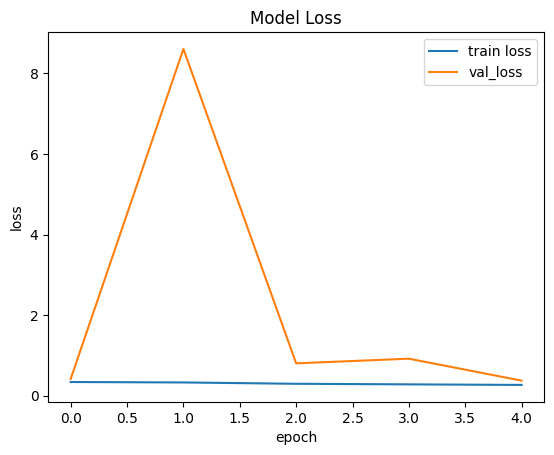

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val_loss']);

# Custom Layers

In [30]:
class NeuralearnDense(Layer):
    def __init__(self, output_units, activation):
        super(NeuralearnDense, self).__init__()
        self.output_units = output_units
        self.activation = activation

    def build(self, input_features_shape):
        self.w = self.add_weight(shape = (input_features_shape[-1], self.output_units), initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape = (self.output_units,), initializer='random_normal', trainable=True)

    def call(self, input_features):
        pre_output = tf.matmul(input_features, self.w) + self.b
        if(self.activation == 'relu'):
            return tf.nn.relu(pre_output)

        elif (self.activation == 'sigmoid'):
            return tf.math.sigmoid(pre_output)

        else :
            return pre_output

### Calling Custom Layers

In [31]:
lenet_custom_layer_model = tf.keras.Sequential([
    InputLayer(input_shape=(im_size, im_size, 3)),
    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='sigmoid'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='sigmoid'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    NeuralearnDense(100, activation='sigmoid'),
    BatchNormalization(),
    NeuralearnDense(10, activation='relu'),
    BatchNormalization(),
    NeuralearnDense(1, activation='sigmoid')
])

lenet_custom_layer_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_22 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_23 (Ba  (None, 109, 109, 16)      64        
 tchNormalization)                                               
                                                      

In [32]:
# Model Compiler
lenet_custom_layer_model.compile(optimizer=Adam(learning_rate=0.1),
              loss = BinaryCrossentropy(),
              metrics='accuracy'
              )

In [33]:
history = lenet_custom_layer_model.fit(train_dataset, validation_data = val_dataset, epochs=5, verbose=1)

Epoch 1/5
689/689 [==============================] - 227s 326ms/step - loss: 0.7003 - accuracy: 0.4994 - val_loss: 0.9299 - val_accuracy: 0.4947
Epoch 2/5
689/689 [==============================] - 222s 322ms/step - loss: 0.6959 - accuracy: 0.4986 - val_loss: 0.6958 - val_accuracy: 0.4976
Epoch 3/5
689/689 [==============================] - 223s 323ms/step - loss: 0.6985 - accuracy: 0.4979 - val_loss: 0.6983 - val_accuracy: 0.5071
Epoch 4/5
689/689 [==============================] - 224s 325ms/step - loss: 0.6975 - accuracy: 0.4974 - val_loss: 0.7867 - val_accuracy: 0.5060
Epoch 5/5
689/689 [==============================] - 220s 320ms/step - loss: 0.6973 - accuracy: 0.4977 - val_loss: 0.7199 - val_accuracy: 0.4944


# Model Evaluation (Accuracy, Precision, Recall)

In [34]:
metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'),
           FalseNegatives(name='fn'), BinaryAccuracy(name='accuracy'), 
           Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

In [35]:
# Model Compiler
lenet_custom_layer_model.compile(optimizer=Adam(learning_rate=0.1),
              loss = BinaryCrossentropy(),
              metrics=metrics
              )

In [36]:
history = lenet_custom_layer_model.fit(train_dataset, validation_data = val_dataset, epochs=5, verbose=1)

Epoch 1/5
689/689 [==============================] - 229s 329ms/step - loss: 0.6982 - tp: 5612.0000 - fp: 5687.0000 - tn: 5336.0000 - fn: 5411.0000 - accuracy: 0.4966 - precision: 0.4967 - recall: 0.5091 - auc: 0.4958 - val_loss: 0.7387 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1367.0000 - val_fn: 1388.0000 - val_accuracy: 0.4962 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5011
Epoch 2/5
689/689 [==============================] - 218s 317ms/step - loss: 0.6964 - tp: 5491.0000 - fp: 5418.0000 - tn: 5604.0000 - fn: 5533.0000 - accuracy: 0.5033 - precision: 0.5033 - recall: 0.4981 - auc: 0.5050 - val_loss: 1.1411 - val_tp: 1384.0000 - val_fp: 1369.0000 - val_tn: 1.0000 - val_fn: 1.0000 - val_accuracy: 0.5027 - val_precision: 0.5027 - val_recall: 0.9993 - val_auc: 0.5000
Epoch 3/5
689/689 [==============================] - 211s 305ms/step - loss: 0.6998 - tp: 5088.0000 - fp: 4992.0000 - tn: 6030.0000 - fn: 5936.0000 - accuracy: 0.5043 - precision: 0.5048 - r

### Model Evaluation

In [37]:
test_dataset = test_dataset.batch(1)
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [38]:
lenet_custom_layer_model.evaluate(test_dataset)

2757/2757 [==============================] - 20s 7ms/step - loss: 0.6930 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1391.0000 - fn: 1366.0000 - accuracy: 0.5045 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5004


[0.6930381655693054,
 0.0,
 0.0,
 1391.0,
 1366.0,
 0.5045338869094849,
 0.0,
 0.0,
 0.5003594160079956]

### Visualizing Confusion Metrix

In [39]:
labels = []
inp = []
for x, y in test_dataset.as_numpy_iterator():
    labels.append(y)
    inp.append(x)
labels 

[array([1], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([1], 

In [40]:
print(np.array(inp).shape)
print(np.array(inp)[:, 0,...].shape)

(2757, 1, 224, 224, 3)
(2757, 224, 224, 3)


In [41]:
labels = np.array([i[0] for i in labels ])
labels

array([1, 1, 0, ..., 0, 1, 1], dtype=int64)

In [42]:
predicted = lenet_model.predict(np.array(inp)[:, 0,...])

print(predicted.shape)
predicted[:, 0]

87/87 [==============================] - 6s 48ms/step
(2757, 1)


array([0.38986364, 0.38869584, 0.3889715 , ..., 0.38978943, 0.3881269 ,
       0.3885914 ], dtype=float32)

#### Confusion Metrix

In [43]:
threshold = 0.5 

cm = confusion_matrix(labels, predicted > threshold)
cm

array([[1392,    0],
       [1365,    0]], dtype=int64)

Text(0.5, 58.7222222222222, 'Predicted')

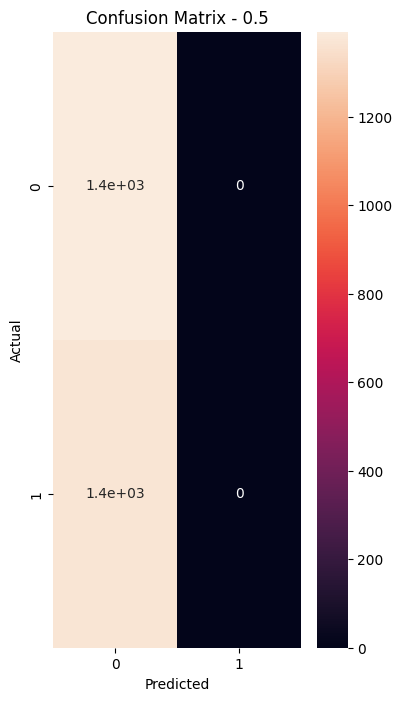

In [47]:
# Plot
plt.figure(figsize=(4,8))
sns.heatmap(cm, annot=True)
plt.title(f"Confusion Matrix - {threshold}")
plt.ylabel("Actual")
plt.xlabel("Predicted")

## ROC Plot

In [ ]:
fp, tp, threshold = roc_curve(labels, predicted)
print(len(fp), len(tp), len(threshold))

In [ ]:
# Plot ROC Curve
plt.plot(fp, tp)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.show()